<a href="https://colab.research.google.com/github/tkhan3/machinelearning/blob/master/k_means_document.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
#import pandas as pd
!google-drive-ocamlfuse drive
!apt-get -qq install -y graphviz && pip install -q pydot
!pip3 install seaborn==0.9.0
import pydot
!mkdir -p drive
!google-drive-ocamlfuse drive
!pip install sklearn_pandas

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131352 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import os
from os import chdir,listdir,path,getcwd
from sys import argv,exit
import pandas as pd
import re
#from mkl import *
import numpy as np
import pickle
import datetime
import timeit
from collections import Counter
from copy import deepcopy
from math import floor,ceil
from scipy.stats import gaussian_kde
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_samples,silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples,silhouette_score
import string

In [2]:
from keras.models import Model
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout, Embedding, LSTM, MaxPooling1D, Flatten
from keras.layers import Convolution1D, AveragePooling1D, Conv1D, Input, GlobalAveragePooling1D
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Nadam, RMSprop
from keras.utils.np_utils import to_categorical
from keras.models import load_model

Using TensorFlow backend.


In [0]:
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from sklearn.manifold import TSNE
import colorsys

In [0]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.gridspec as gridspec

In [0]:
%matplotlib inline

In [0]:
def get_tfidf(data):
  tf=TfidfVectorizer(input='content',analyzer='word',min_df=5,stop_words='english',max_features =20000)
  X=tf.fit_transform(data)
  X=X.todense()
  return X


In [0]:
def get_tfidf_truncSVD_features(df, fs_text = 'text', ngram_range = (1, 1),min_df = 5, n_components = 600,verbose = 1):
  if verbose > 0:
    print('TFIDF transformation started')
  tfidf_model = TfidfVectorizer(stop_words = 'english', ngram_range = ngram_range,min_df = min_df)
  tfidf = tfidf_model.fit_transform(df[fs_text].values)
  if verbose > 0: print('TFIDF transformation complete')
  tsvd_model = TruncatedSVD(n_components = n_components).fit(tfidf)
  if verbose > 0: print('tSVD model fit complete')
  print('Explained variance:', np.sum(tsvd_model.explained_variance_ratio_))   
  tsvd = tsvd_model.transform(tfidf)
  if verbose > 0: print('tSVD transformation complete')
  tsvd = pd.DataFrame(tsvd)
  fe_columns = ['tfidf_tSVD_' + str(i) for i in range(n_components)]
  tsvd.columns = fe_columns
  df = df.join(tsvd)
  fs_ind = fe_columns
  plt.figure()
  plt.plot(np.cumsum(tsvd_model.explained_variance_ratio_))
  plt.xlabel('Number of Components')
  plt.ylabel('Variance (%)') #for each component
  return df,tsvd_model,tfidf_model

In [0]:
def trSVD(n_comp,X):
  lsa = TruncatedSVD(n_components=n_comp)
  X_lsa = lsa.fit_transform(X)
  compo=lsa.components_ 
  return lsa, X_lsa,compo

In [0]:
def Km_clust(data,n_clu):
	km=KMeans(n_clusters=n_clu,random_state=123)
	km_tr=km.fit_transform(data)
	km_labels=km.fit_predict(data)    
	km_lab=km.labels_
	centroids=km.cluster_centers_
	return km,km_labels#,km_tr,centroids,km_lab

In [0]:
def silh_scre(Xlsa,km_lab):    
    silh_avg=silhouette_score(Xlsa,km_lab)
    silh_values=silhouette_samples(Xlsa,km_lab)
    return silh_avg,silh_values

In [0]:
def diff_Kmeans(feature_matrix,range_of_n,verbose=1):
    KM_dict={}
    for n_clusters in range_of_n:
	    if verbose>0: print (datetime.datetime.now())
	    if verbose>0: print ('Running for '+str(n_clusters)+' clusters...')
	    KM_n=Km_clust(feature_matrix,n_clusters)
	    silhouette_average=silhouette_score(feature_matrix,KM_n[1])
	    if verbose>0: print (datetime.datetime.now())
	    sample_silhoutte_values=silhouette_samples(feature_matrix,KM_n[1])
	    KM_dict[n_clusters]=[KM_n[0],KM_n[1],sample_silhoutte_values,silhouette_average]
    return KM_dict

In [0]:
def clean_up(rec):
  table = str.maketrans({key: None for key in string.punctuation})
  rec = str(rec)
  rec = rec.replace('\\n','').replace('\\r','')
  rec = re.sub(r'[^a-zA-Z0-9\.,;?<>/ ]',r'',rec)
  #rec = re.sub(r'\w*\d\w*', '', rec)
  rec = rec.strip()
  rec = re.sub(' +', ' ',rec)
  rec = rec.translate(table)
  rec = rec.lower()
  return rec

In [0]:
def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)

In [0]:
def tsne(n_comp,data):
    tsne_result=TSNE(n_components=n_comp).fit_transform(data)
    return tsne_result

In [0]:
def get_colors(num_colors=5):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

In [0]:
def cluster_colors(lab, n_clust): #For generating colors: lab is the labels resulting from any clusteing algorithm
    j= lab
    col=get_colors(n_clust)
    col1=[]
    for x in j:
        j1 = x
        j1 = int(j1)
        col1.append(col[j1])
    return col1

In [0]:
def tsne_plt(tsne_r,color):
    plt.figure(figsize=(5,5))
    ax = plt.axes(frameon=False)
    plt.setp(ax, xticks=(), yticks=())
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                    wspace=0.0, hspace=0.0)
    plt.scatter(tsne_r[:,0],tsne_r[:,1],marker='*',s=10,color=color)
    return plt.show()


In [0]:
def tsne_plt_cent(tsne_r,n_clust,lab,color):
    cent_x=[]
    cent_y=[]
    plotlabel=[]
    marker_color=get_colors(n_clust)
    mytsne=(tsne_r[:,0],tsne_r[:,1],lab)    
    for i in range(0,n_clust):
        labindex = np.where(lab==i)[0]
        myx=[]
        myy=[]
        for k in labindex:
            try:
                myx.append(mytsne[0][k])
                myy.append(mytsne[1][k])
            except Exception as e:
                print (str(e))
                print (k)
                exit(1)
        #myx = list(chain(*myx))
        #myy = list(chain(*myy))
        cent_x.append(np.mean(myx))
        cent_y.append(np.mean(myy))
        plotlabel.append(i)
    plt.figure(figsize=(30,40))
    ax = plt.axes(frameon=False)
    plt.setp(ax, xticks=(), yticks=())
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                    wspace=0.0, hspace=0.0)
    plt.scatter(tsne_r[:,0], tsne_r[:,1],marker='o',s=2,color=color)
    plt.scatter(cent_x, cent_y,marker='s', edgecolor='black', linewidth='3', facecolor=marker_color, hatch='|',s=20)
    #plt.xlim(-15,15)
    #plt.ylim(-15,15)
    for i, txt in enumerate(plotlabel):
        ax.annotate(txt, (cent_x[i], cent_y[i]))
    return plt.show()

In [0]:
import os
drive_path = 'drive/DL_COLAB/'

TICKET_ANALYTICS_PATH = os.path.join(drive_path,"text_analytics","ticket_analysis")

def load_ticket_data(filename, file_path=TICKET_ANALYTICS_PATH):
    csv_path = os.path.join(file_path, filename)
    return pd.read_csv(csv_path,sep=",")

In [0]:
ticket_data_full = load_ticket_data("Telco_Apr-2016.csv",TICKET_ANALYTICS_PATH)

In [0]:
FIELDS = ["Defect ID","Title","Problem Details","Resolution Details","Root Cause"]

In [0]:
ticket_data = ticket_data_full[FIELDS]

In [0]:
problem_desc_list = ticket_data[['Problem Details']].values.tolist()

In [0]:
problem_desc_cleanned = [clean_up(item) for item in problem_desc_list]

In [0]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=60).generate(''.join(problem_desc_cleanned))

In [29]:
problem_desc_cleanned[1:10]

['reason and sub reason section not updated under auc004 and auc005 in dbrd v007',
 'no functional requirements for auc003 dealer changes number of bulk receivers ba will add frs related to auc003',
 'no functional requirements for auc005 dealer places upgrade order ba added frs covering auc005',
 'should be automatically defaulting to all included when it is just going to general market right now',
 'auc covering migration of properties to bulk is missing there are two functional requirements present but no auc ba listed them under deployment option after several discussions ba was convinced to add auc for that purpose',
 'no auc nor functional requirements separation for fulfillment and nonfulfillment dealer activations ba agreed to add auc for nonfulfillment and fulfillment dealer receiver activation dws is uded to activate nonfulfillment fstp riocc and ivr are used for fulfillment dealer activations',
 'confirmation letter codes not updated in cor v200',
 'when attempting to upgrad

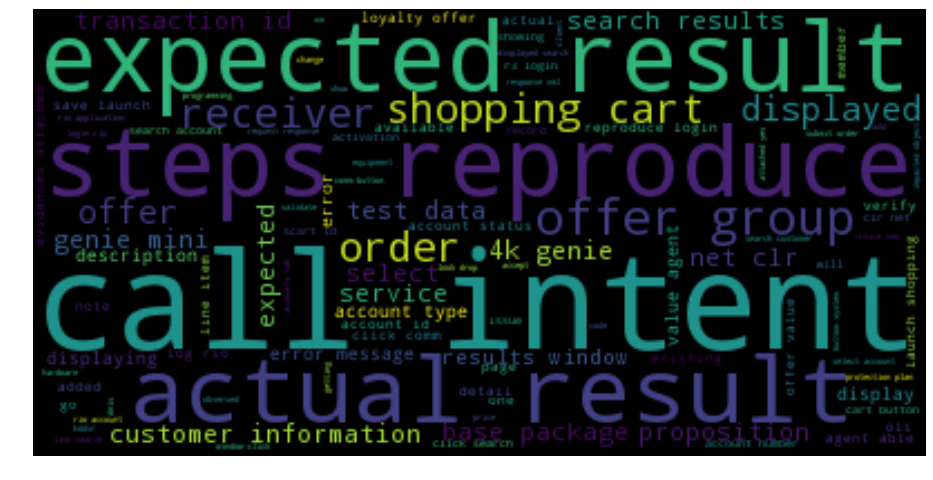

In [28]:
plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [0]:
problem_desc_cleanned_df = pd.DataFrame(problem_desc_cleanned,columns=['Problem Details'])

In [152]:
problem_desc_cleanned_df.loc[1:10,:]

,Problem Details
1,reason and sub reason section not updated unde...
2,no functional requirements for auc003 dealer c...
3,no functional requirements for auc005 dealer p...
4,should be automatically defaulting to all incl...
5,auc covering migration of properties to bulk i...
6,no auc nor functional requirements separation ...
7,confirmation letter codes not updated in cor v200
8,when attempting to upgrade the customer receiv...
9,warranty out offers are showing for the accoun...
10,oms did not default to all included and 1012 w...


TFIDF transformation started
TFIDF transformation complete
tSVD model fit complete
Explained variance: 0.9995731518614177
tSVD transformation complete


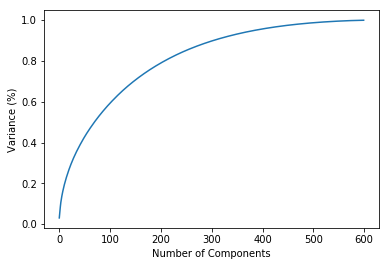

In [260]:
truncTFIDF,tsvd_model,tfidf_model = get_tfidf_truncSVD_features(df=problem_desc_cleanned_df,fs_text='Problem Details',ngram_range = (2, 2),min_df = 5, n_components = 600)

TFIDF transformation started
TFIDF transformation complete
tSVD model fit complete
Explained variance: 0.9991814315930118
tSVD transformation complete


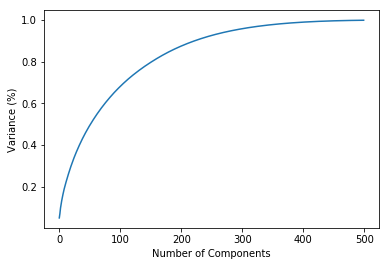

In [266]:
truncTFIDF,tsvd_model,tfidf_model = get_tfidf_truncSVD_features(df=problem_desc_cleanned_df,fs_text='Problem Details',ngram_range = (2, 2),min_df = 5, n_components = 500)

In [0]:
feature_matrix=np.matrix(truncTFIDF[[x for x in truncTFIDF.columns if re.match('tfidf',x)]])

In [268]:
feature_matrix.shape

(622, 500)

In [0]:
range_n_clusters=range(5,11)

In [270]:
KM_info=diff_Kmeans(feature_matrix,range_n_clusters)

2019-02-22 18:54:09.916014
Running for 5 clusters...
2019-02-22 18:54:10.496951
2019-02-22 18:54:10.516402
Running for 6 clusters...
2019-02-22 18:54:11.218263
2019-02-22 18:54:11.238174
Running for 7 clusters...
2019-02-22 18:54:11.833190
2019-02-22 18:54:11.853128
Running for 8 clusters...
2019-02-22 18:54:12.544210
2019-02-22 18:54:12.564652
Running for 9 clusters...
2019-02-22 18:54:13.223877
2019-02-22 18:54:13.243559
Running for 10 clusters...
2019-02-22 18:54:13.994437


In [245]:
KM_info.keys()

dict_keys([5, 6, 7, 8, 9, 10])

5


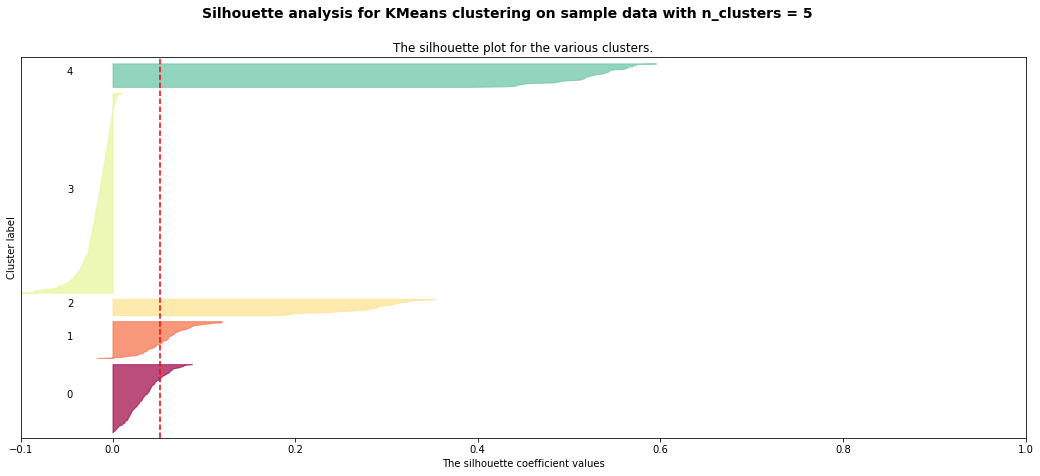

In [247]:
temp_range=[5]
#temp_range = range_n_clusters

# In[159]:

y_lower = 10

for n_clusters in temp_range:
    print (n_clusters)
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(feature_matrix) + (n_clusters + 1) * 10])    
    #print ("For number of clusters "+str(n_clusters)+" the average silhoutte score is :"+str(KM_info[n_clusters][3]))
    for i in range(n_clusters):
        ith_cluster_silhouette_values = KM_info[n_clusters][2][KM_info[n_clusters][1] == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=KM_info[n_clusters][3], color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

[5]


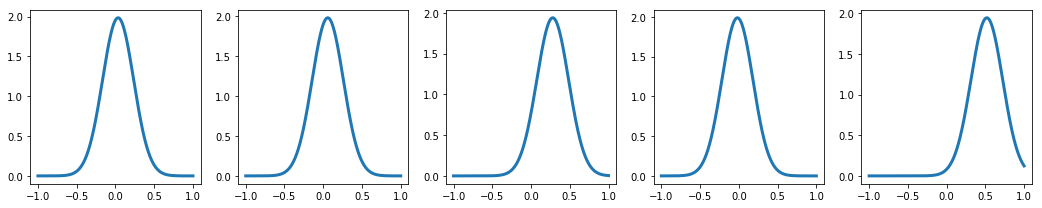

In [248]:
print (temp_range)
x_grid = np.linspace(-1, 1, 1000)
for n_clusters in temp_range:
    n_cols=5
    n_rows=n_clusters/5
    gs=gridspec.GridSpec(int(n_rows),int(n_cols))
    #fig = plt.figure()
    fig_height = 3*n_rows
    plot_aspect_ratio=1.62
    fig = plt.figure(figsize=(fig_height  * plot_aspect_ratio*3, fig_height ))
    j=0
    for i in range(n_clusters):
        ith_cluster_silhouette_values = KM_info[n_clusters][2][KM_info[n_clusters][1] == i]
        ith_cluster_silhouette_values.sort()
        ax = fig.add_subplot(gs[j])        
        density = kde_statsmodels_u(ith_cluster_silhouette_values,x_grid)
        ax.plot(x_grid,density,lw=3)
        ax.set_xticks([-1,-0.5,0
                       ,0.5,1])
        j=j+1
fig.tight_layout()
fig.show()

In [0]:
tsne_r=tsne(2,feature_matrix)

In [0]:
clust_cols=cluster_colors(KM_info[5][1],5)

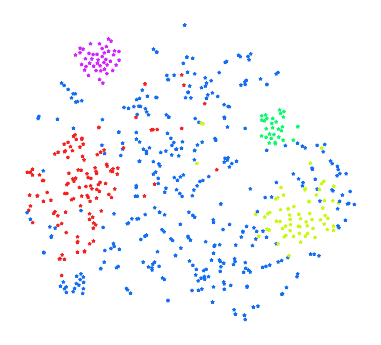

In [251]:
tsne_plt(tsne_r,clust_cols)

In [0]:
original_space_centroids = tsvd_model.inverse_transform(KM_info[5][0].cluster_centers_)

In [264]:
original_space_centroids.shape

(5, 2096)

In [0]:
order_centroids = original_space_centroids.argsort()[:, ::-1]

In [0]:
terms = tfidf_model.get_feature_names()

In [1]:
for i in range(5):
  print("Cluster %d:" % i, end='')
  for ind in order_centroids[i, :10]:
    print(' %s' % terms[ind], end='')
    print()

Cluster 0:

NameError: ignored